#Importar librerias y funciones

In [ ]:
'''

This code is related to the paper :
[Identifying neuropathies through time series analyses of postural tests, 
Claudio Meneses V., Jorge Littin C., David Coo A., Juan Guerrero-Henriquez, Martin Vargas M.] 

If you use this algorithm in your research work, please cite this paper.


'''

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import skew
from sklearn import preprocessing
import pandas as pd
import networkx as nx
import seaborn as sns
from scipy.linalg import eigh
import math

sns.set()


def calcular_RMS(df):
  return  np.sqrt(np.mean(df **2))  #np.mean(df)

def calcular_vel_global(x, y):
  vel_x = pd.DataFrame()
  vel_y = pd.DataFrame()
  vel_x = (pd.DataFrame.diff(x / 0.04))
  vel_y = (pd.DataFrame.diff(y / 0.04))
  return vel_x[1:], vel_y[1:]

def calcular_acc_global(x, y):
  acc_x = pd.DataFrame()
  acc_y = pd.DataFrame()
  acc_x = pd.DataFrame.diff(pd.DataFrame.diff(x / 0.04))
  acc_y = pd.DataFrame.diff(pd.DataFrame.diff(y / 0.04))
  return acc_x[2:], acc_y[2:]

def calcular_jerk_global(x, y):
  #a = np.empty((498,2))
  jerk_x = pd.DataFrame()
  jerk_y = pd.DataFrame()
  jerk_x = pd.DataFrame.diff(pd.DataFrame.diff(pd.DataFrame.diff(x / 0.04)))
  jerk_y = pd.DataFrame.diff(pd.DataFrame.diff(pd.DataFrame.diff(y / 0.04)))
  return jerk_x[3:], jerk_y[3:]  



#Cargar archivos txt

In [ ]:
ruta = ['/content/drive/My Drive/Magister/Tesis/Datasets_porExamen/Sano/',
            '/content/drive/My Drive/Magister/Tesis/Datasets_porExamen/SNp/',
            '/content/drive/My Drive/Magister/Tesis/Datasets_porExamen/Np/']
Examen = ['EBOA','EBOASI','EBOATD','EBOASITD','EBOC','EBOCSI','EBOCTD','EBOCSITD']

def find_file(ruta):
    #Arreglo para guardar la ruta de los archivos encontrados.
    files = []
    for dirName, subdirList, fileList in os.walk(ruta):
          #Se agrega directorio completo y nombre del archivo.
          files.append([os.path.join(dirName, f) for f in fileList  ])
    return files

archivos = []

val_x0, val_x1, val_x2 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
val_y0, val_y1, val_y2 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
class_attribute = pd.DataFrame(columns={'Exam','Class', 'Ruta'})
Exam = pd.DataFrame()
for valor in enumerate(ruta):
  i = 0 
  print('Clase:',valor[0], valor[1])
  
  for carpeta in Examen:
    archivos = find_file(valor[1]+carpeta)
    for batch in archivos:
      if(len(batch) != 0):
        print(batch)

        for archivo in range(len(batch)):
          print(':', batch[archivo])
          df_aux = pd.read_csv(str(batch[archivo]), sep=';', decimal=',', usecols=[1,2])
          print(i)
          if(valor[0] == 0):    
    
            val_x0.insert(i, i, df_aux['x'])
            val_y0.insert(i, i, df_aux['y'])
            class_attribute = class_attribute.append({'Exam' : carpeta, 'Class' : 0, 'Ruta' : batch[archivo]}, ignore_index=True)
          if(valor[0] == 1):
            
            val_x1.insert(i, i, df_aux['x'])
            val_y1.insert(i, i, df_aux['y'])
            class_attribute = class_attribute.append({'Exam' : carpeta, 'Class' : 1, 'Ruta' : batch[archivo]}, ignore_index=True)
          if(valor[0] == 2):
            
            val_x2.insert(i, i, df_aux['x'])
            val_y2.insert(i, i, df_aux['y'])
            class_attribute = class_attribute.append({'Exam' : carpeta, 'Class' : 2, 'Ruta' : batch[archivo]}, ignore_index=True)
          i += 1
    #break

Clase: 0 /content/drive/My Drive/Magister/Tesis/Datasets_porExamen/Sano/
['/content/drive/My Drive/Magister/Tesis/Datasets_porExamen/Sano/EBOA/OASE_SWARII.txt', '/content/drive/My Drive/Magister/Tesis/Datasets_porExamen/Sano/EBOA/EBOA_SWARII.txt', '/content/drive/My Drive/Magister/Tesis/Datasets_porExamen/Sano/EBOA/OASE_SWARII (2).txt', '/content/drive/My Drive/Magister/Tesis/Datasets_porExamen/Sano/EBOA/OASE_SWARII (3).txt', '/content/drive/My Drive/Magister/Tesis/Datasets_porExamen/Sano/EBOA/OASE_SWARII (4).txt', '/content/drive/My Drive/Magister/Tesis/Datasets_porExamen/Sano/EBOA/EBOA_SWARII (2).txt', '/content/drive/My Drive/Magister/Tesis/Datasets_porExamen/Sano/EBOA/OASE_SWARII (5).txt', '/content/drive/My Drive/Magister/Tesis/Datasets_porExamen/Sano/EBOA/OASE_SWARII (6).txt', '/content/drive/My Drive/Magister/Tesis/Datasets_porExamen/Sano/EBOA/EBOA_SWARII (3).txt', '/content/drive/My Drive/Magister/Tesis/Datasets_porExamen/Sano/EBOA/OASE_SWARII (7).txt', '/content/drive/My Drive

#Calcular derivadas

In [ ]:
#Calcular aceleracion
acc_x0, acc_y0 = calcular_acc_global(val_x0, val_y0)
acc_x1, acc_y1 = calcular_acc_global(val_x1, val_y1)
acc_x2, acc_y2 = calcular_acc_global(val_x2, val_y2)
#Calcular jerk
j_x0, j_y0 = calcular_jerk_global(val_x0, val_y0)
j_x1, j_y1 = calcular_jerk_global(val_x1, val_y1)
j_x2, j_y2 = calcular_jerk_global(val_x2, val_y2)

#Calcular velocidad (opcional)
vel_x0, vel_y0 = calcular_vel_global(val_x0, val_y0)
vel_x1, vel_y1 = calcular_vel_global(val_x1, val_y1)
vel_x2, vel_y2 = calcular_vel_global(val_x2, val_y2)

#Mostrar dimensiones
print(acc_x0.shape, acc_x1.shape, acc_x2.shape)

(498, 87) (498, 145) (498, 201)


#Calcular curva promedio RMS

In [ ]:
# Calcular curva promedio por RMS #

umb_val0, umb_val1, umb_val2 = pd.DataFrame(columns={'x','y'}), pd.DataFrame(columns={'x','y'}), pd.DataFrame(columns={'x','y'})
umb_acc0, umb_acc1, umb_acc2 = pd.DataFrame(columns={'x','y'}), pd.DataFrame(columns={'x','y'}), pd.DataFrame(columns={'x','y'})
umb_j0, umb_j1, umb_j2 = pd.DataFrame(columns={'x','y'}), pd.DataFrame(columns={'x','y'}), pd.DataFrame(columns={'x','y'})

#Sanos

for col in range(len(val_x0)):
  umb_val0 = umb_val0.append({'x': calcular_RMS(val_x0.iloc[col,:]),
                              'y': calcular_RMS(val_y0.iloc[col,:])}, ignore_index=True)
for col in range(len(acc_x0)):
  umb_acc0 = umb_acc0.append({'x': calcular_RMS(acc_x0.iloc[col,:]),
                              'y': calcular_RMS(acc_y0.iloc[col,:])}, ignore_index=True)
for col in range(len(j_x0)):
  umb_j0 = umb_j0.append({'x': calcular_RMS(j_x0.iloc[col,:]),
                          'y': calcular_RMS(j_y0.iloc[col,:])}, ignore_index=True)

#SNp
for col in range(len(val_x1)):
  umb_val1 = umb_val1.append({'x': calcular_RMS(val_x1.iloc[col,:]),
                              'y': calcular_RMS(val_y1.iloc[col,:])}, ignore_index=True)
for col in range(len(acc_x1)):
  umb_acc1 = umb_acc1.append({'x': calcular_RMS(acc_x1.iloc[col,:]),
                              'y': calcular_RMS(acc_y1.iloc[col,:])}, ignore_index=True)
for col in range(len(j_x1)):
  umb_j1 = umb_j1.append({'x': calcular_RMS(j_x1.iloc[col,:]),
                          'y': calcular_RMS(j_y1.iloc[col,:])}, ignore_index=True)

#Np
for col in range(len(val_x2)):
  umb_val2 = umb_val2.append({'x': calcular_RMS(val_x2.iloc[col,:]),
                              'y': calcular_RMS(val_y2.iloc[col,:])}, ignore_index=True)
for col in range(len(acc_x2)):
  umb_acc2 = umb_acc2.append({'x': calcular_RMS(acc_x2.iloc[col,:]),
                              'y': calcular_RMS(acc_y2.iloc[col,:])}, ignore_index=True)
for col in range(len(j_x2)):
  umb_j2 = umb_j2.append({'x': calcular_RMS(j_x2.iloc[col,:]),
                          'y': calcular_RMS(j_y2.iloc[col,:])}, ignore_index=True)


#Concatenar dataframe

In [ ]:
#Concatenar dataframes #
dataset, dataset1, dataset2, dataset3 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

dataset1 = pd.concat([umb_val0, umb_acc0, umb_j0], axis=1, ignore_index=True)
dataset2 = pd.concat([umb_val1, umb_acc1, umb_j1], axis=1, ignore_index=True)
dataset3 = pd.concat([umb_val2, umb_acc2, umb_j2], axis=1, ignore_index=True)
dataset = pd.concat([dataset1,dataset2,dataset3], axis=0)
dataset['Class'] = 'Healthy'
dataset['Class'][500:1000] = 'Diabetic'
dataset['Class'][1000:] = 'Neuropathic'
#Obtener el tipo de examen (Opcional)
#dataset['Exam'] = class_attribute['Exam']

dataset = dataset.rename(columns={0: "COP_x", 1: "COP_y", 2 : "Acc_x", 3 : "Acc_y", 4 : "Jerk_x", 5 : "Jerk_y"})

print(dataset.shape)
dataset.tail()

(1500, 7)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,COP_x,COP_y,Acc_x,Acc_y,Jerk_x,Jerk_y,Class
495,0.698638,0.749416,0.447488,0.917185,0.327246,0.583607,Neuropathic
496,0.703357,0.742312,0.423801,0.904474,0.368211,0.514052,Neuropathic
497,0.706916,0.744025,0.463391,0.901094,NaN,NaN,Neuropathic
498,0.710549,0.751875,NaN,NaN,NaN,NaN,Neuropathic
499,0.713257,0.767389,NaN,NaN,NaN,NaN,Neuropathic


#Visualizar datos

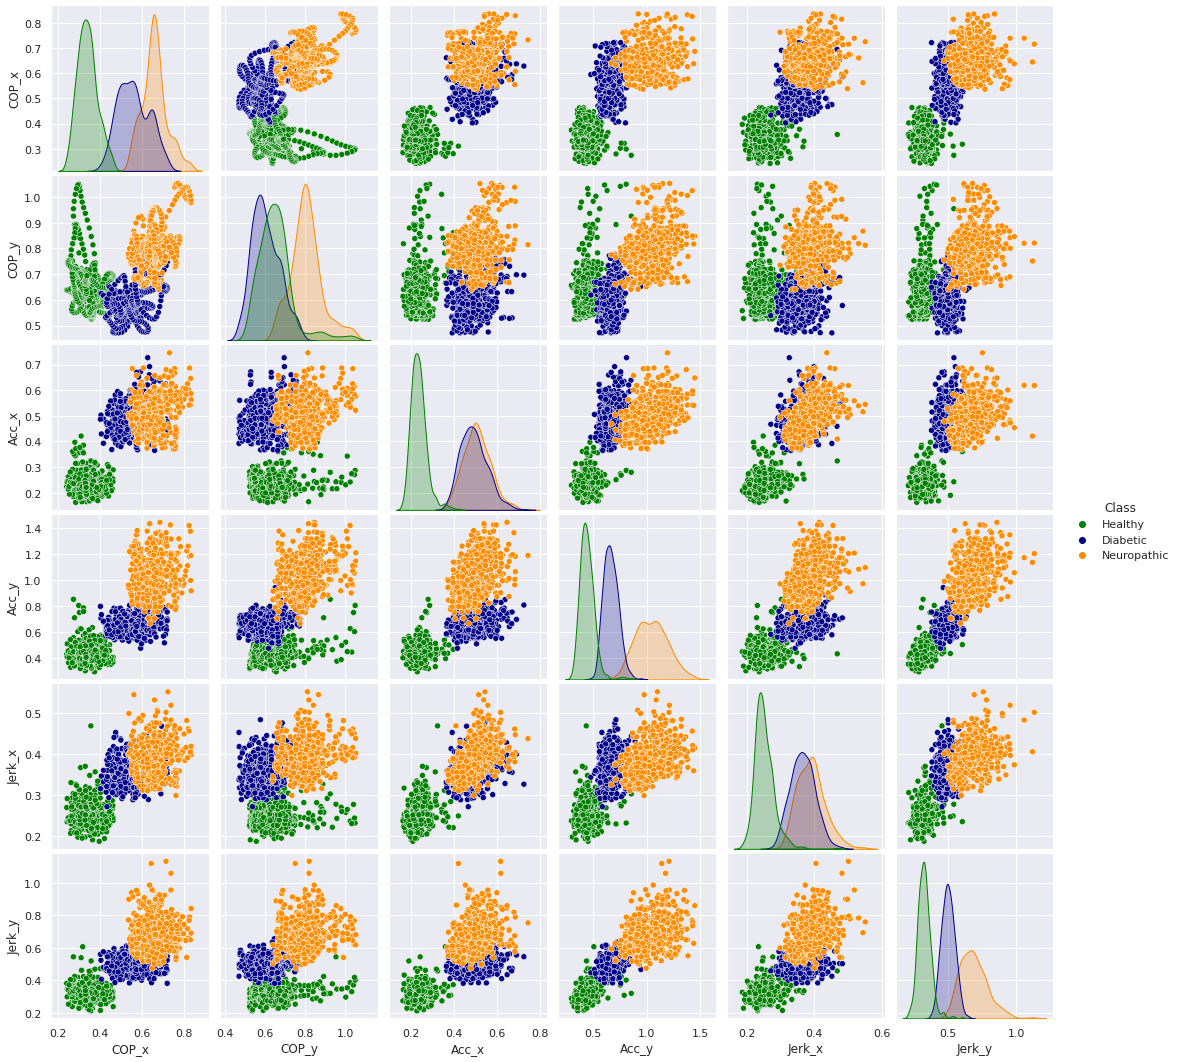

In [ ]:
#Visualizar RMS #
sns.pairplot(dataset, hue='Class',  palette={'Healthy' : 'green', 'Diabetic': 'darkblue', 'Neuropathic' : 'darkorange'})
plt.show()